In [1]:
# Imports para graficos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter
import os

from transformers import BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

/home/thaiswsl/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Análise inicial dos dados

In [5]:
# Verificar se o arquivo 'games_tratado.csv' já existe no diretório
if os.path.exists('data/games_tratado.csv'):
    # Se o arquivo existir, carregar o DataFrame do arquivo CSV
    df = pd.read_csv('data/games_tratado.csv')
    print("Arquivo 'games_tratado.csv' carregado.")
    
    # Remover aspas simples dos gêneros (se existirem)
    df['Genres'] = df['Genres'].apply(lambda x: [genre.replace("'", "") for genre in eval(x)] if isinstance(x, str) else x)

else:
    # Caso o arquivo não exista, criar e processar os dados
    df = pd.read_csv('data/games.csv')
    df = df[['AppID', 'About the game', 'Genres']]
    df = df.rename(columns={'AppID': 'Name'})

    # Dividindo os gêneros em listas e removendo as aspas simples
    df['Genres'] = df['Genres'].str.split(',')
    df['Genres'] = df['Genres'].apply(lambda x: [genre.replace("'", "") for genre in x] if isinstance(x, list) else [])

    # Salvar o DataFrame processado no arquivo
    df.to_csv('data/games_tratado.csv', index=False)
    print("Arquivo 'games_tratado.csv' criado e salvo.")

# O DataFrame 'df' agora contém os dados carregados ou processados
df_analise = df
df.head()

Arquivo 'games_tratado.csv' carregado.


,Name,About the game,Genres
0,Galactic Bowling,Galactic Bowling is an exaggerated and stylize...,"[Casual, Indie, Sports]"
1,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,"[Action, Indie]"
2,Jolt Project,Jolt Project: The army now has a new robotics ...,"[Action, Adventure, Indie, Strategy]"
3,Henosis™,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[Adventure, Casual, Indie]"
4,Two Weeks in Painland,ABOUT THE GAME Play as a hacker who has arrang...,"[Adventure, Indie]"


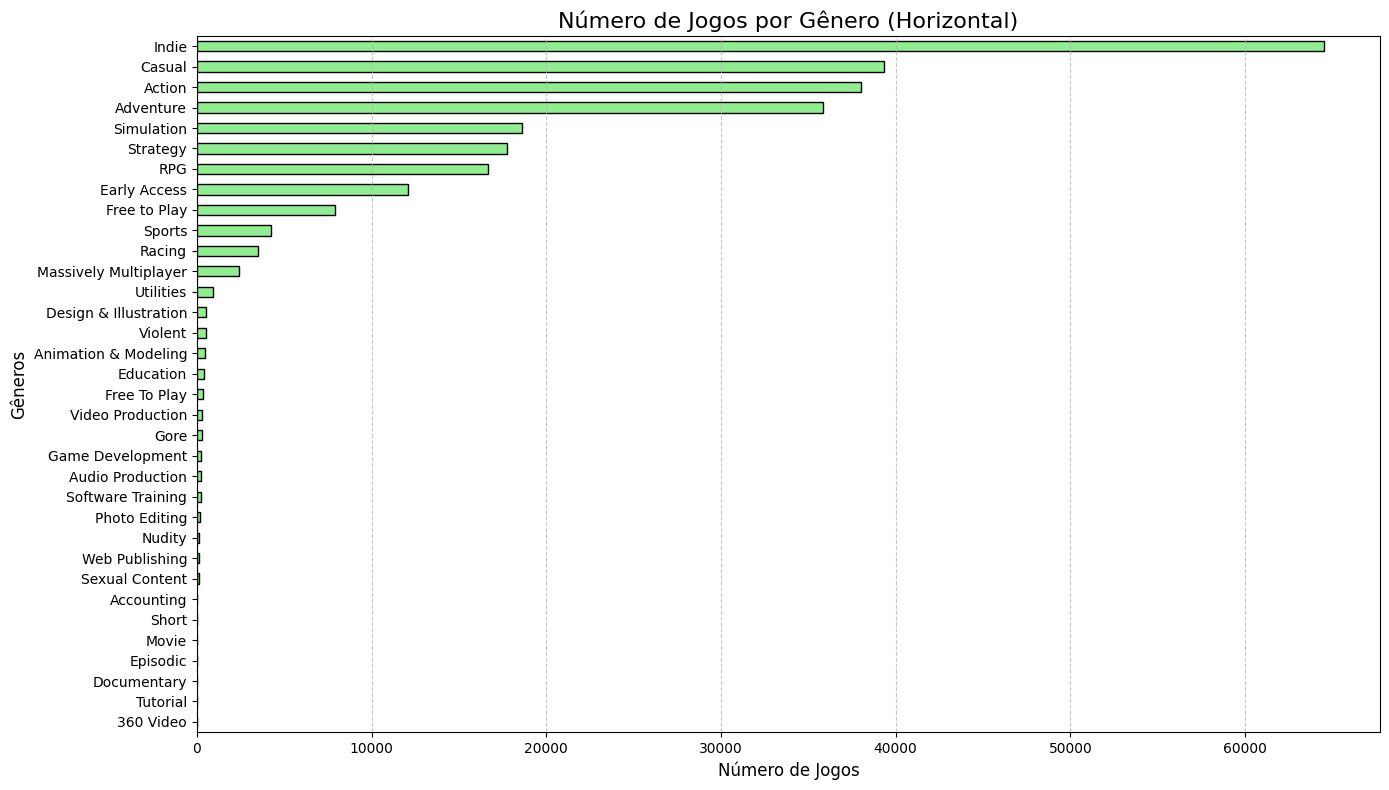

In [6]:
# Transformando cada gênero em uma linha separada
exploded_df = df_analise.explode('Genres')

# Contando o número de jogos por gênero
genre_counts = exploded_df['Genres'].value_counts()

# Plotando o gráfico de barras (horizontal) com a ordem invertida
plt.figure(figsize=(14, 8))
genre_counts[::-1].plot(kind='barh', color='lightgreen', edgecolor='black')
plt.title('Número de Jogos por Gênero (Horizontal)', fontsize=16)
plt.xlabel('Número de Jogos', fontsize=12)
plt.ylabel('Gêneros', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

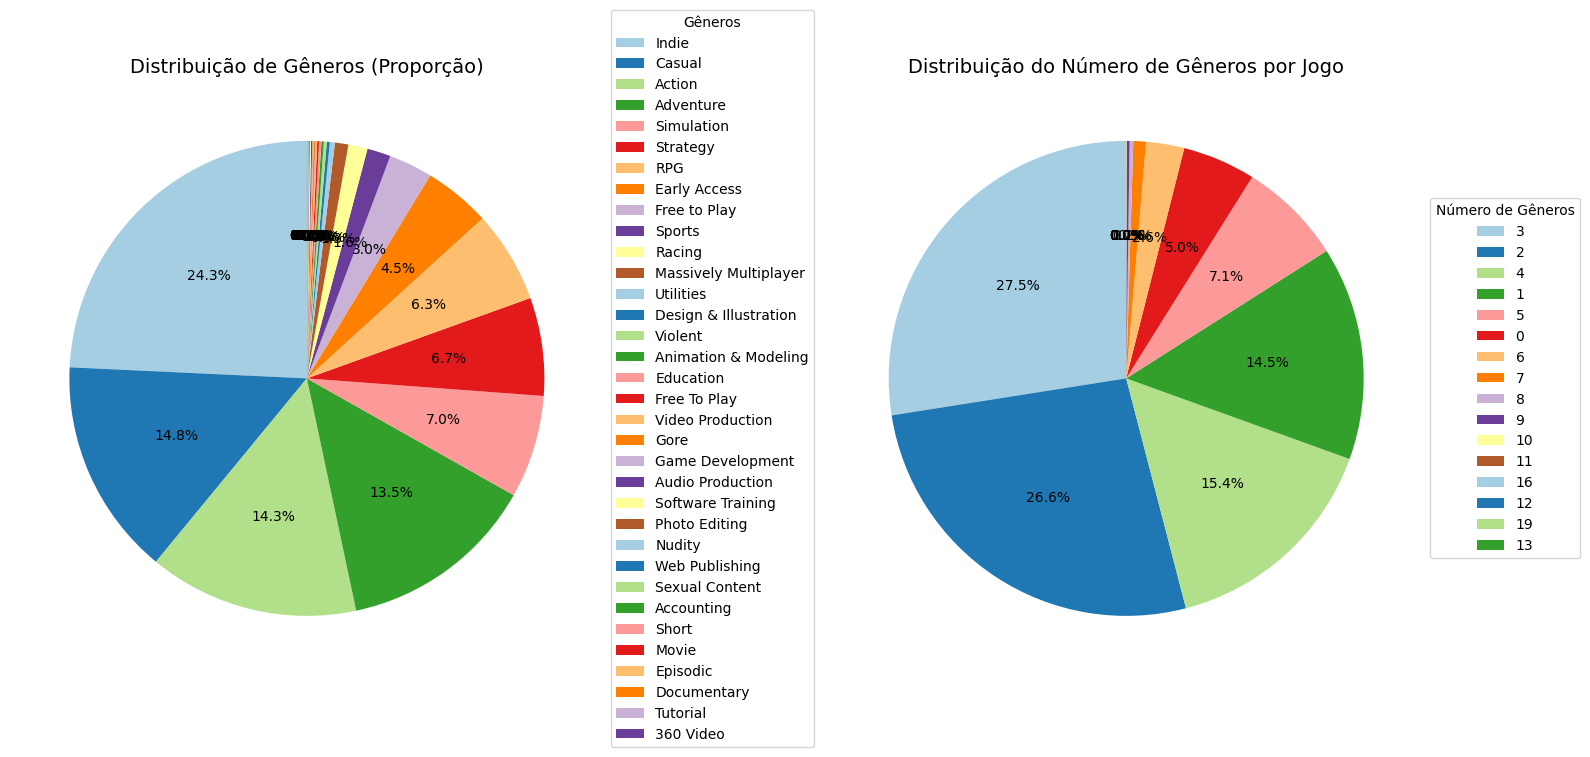

In [7]:
# Contando o número de gêneros por jogo
df_analise['Num_Genres'] = df_analise['Genres'].apply(len)

# Contando a distribuição do número de gêneros por jogo
num_genres_counts = df_analise['Num_Genres'].value_counts()

# Proporção de cada gênero
genre_proportion = genre_counts / genre_counts.sum()

# Criando os subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Gráfico de pizza (Distribuição de Gêneros)
wedges1, texts1, autotexts1 = axes[0].pie(genre_proportion, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[0].set_title('Distribuição de Gêneros (Proporção)', fontsize=14)
axes[0].set_ylabel('')  # Remover o rótulo do eixo y
axes[0].legend(wedges1, genre_proportion.index, title="Gêneros", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Gráfico de pizza (Distribuição do Número de Gêneros por Jogo)
wedges2, texts2, autotexts2 = axes[1].pie(num_genres_counts, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
axes[1].set_title('Distribuição do Número de Gêneros por Jogo', fontsize=14)
axes[1].set_ylabel('')  # Remover o rótulo do eixo y
axes[1].legend(wedges2, num_genres_counts.index.astype(str), title="Número de Gêneros", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

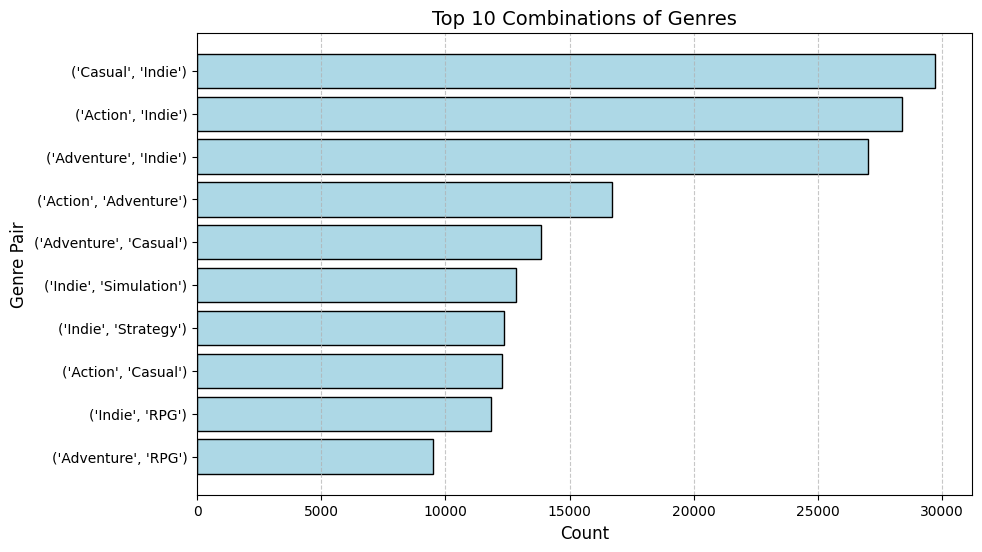

In [8]:
# Criando a lista de combinações de gêneros
genre_combinations = []
for genres in df_analise['Genres']:
    genre_combinations.extend(combinations(genres, 2))

# Contando a frequência das combinações
genre_pair_counts = Counter(genre_combinations)

# Convertendo para DataFrame e ordenando
genre_pairs_df = pd.DataFrame(genre_pair_counts.items(), columns=['Genre Pair', 'Count']).sort_values(by='Count', ascending=False)

# Selecionando as 10 combinações mais frequentes
top_combinations = genre_pairs_df.head(10)

# Criando o gráfico de barras horizontais
plt.figure(figsize=(10, 6))
plt.barh(top_combinations['Genre Pair'].astype(str), top_combinations['Count'], color='lightblue', edgecolor='black')
plt.title('Top 10 Combinations of Genres', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre Pair', fontsize=12)
plt.gca().invert_yaxis()  # Inverter a ordem para exibir a combinação mais frequente no topo
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

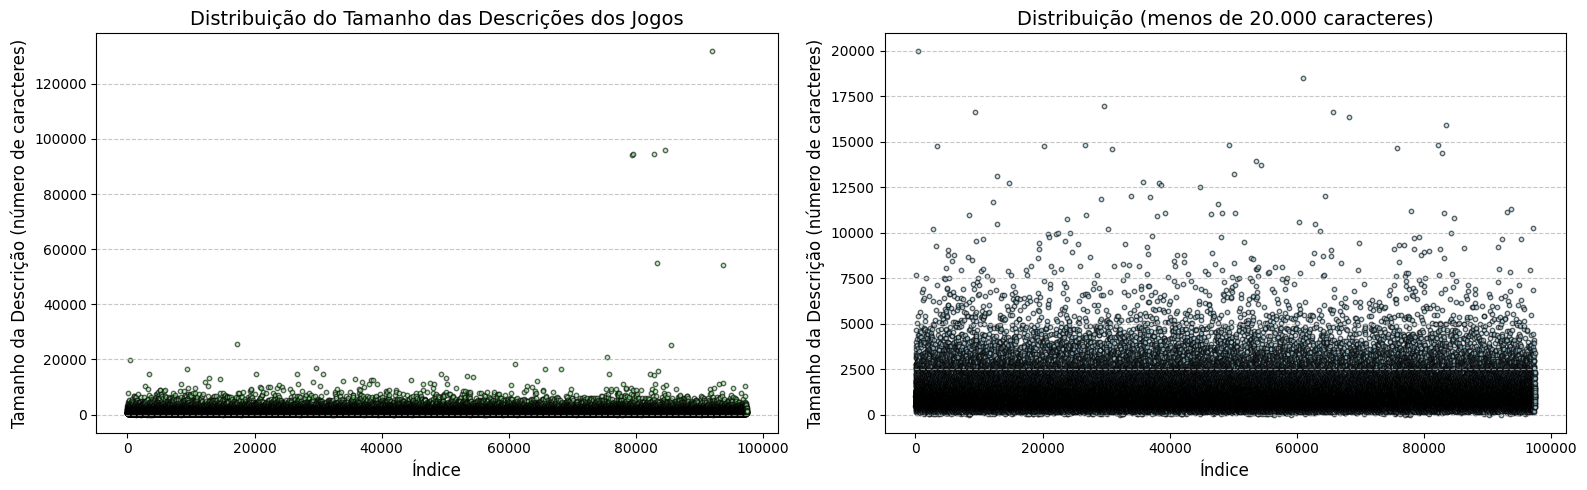

In [9]:
# Calculando o tamanho da descrição
df_analise['Description_Length'] = df_analise['About the game'].str.len()

# Criando os subgráficos
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Primeiro gráfico (todos os dados)
axes[0].scatter(df_analise.index, df_analise['Description_Length'], color='lightgreen', edgecolor='black', alpha=0.6, s=10)
axes[0].set_title('Distribuição do Tamanho das Descrições dos Jogos', fontsize=14)
axes[0].set_xlabel('Índice', fontsize=12)
axes[0].set_ylabel('Tamanho da Descrição (número de caracteres)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Segundo gráfico (apenas valores menores que 20.000 caracteres)
filtered_data = df_analise[df_analise['Description_Length'] < 20000]
axes[1].scatter(filtered_data.index, filtered_data['Description_Length'], color='lightblue', edgecolor='black', alpha=0.6, s=10)
axes[1].set_title('Distribuição (menos de 20.000 caracteres)', fontsize=14)
axes[1].set_xlabel('Índice', fontsize=12)
axes[1].set_ylabel('Tamanho da Descrição (número de caracteres)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [10]:
df_analise.head()

,Name,About the game,Genres,Num_Genres,Description_Length
0,Galactic Bowling,Galactic Bowling is an exaggerated and stylize...,"[Casual, Indie, Sports]",3,1043.0
1,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,"[Action, Indie]",2,491.0
2,Jolt Project,Jolt Project: The army now has a new robotics ...,"[Action, Adventure, Indie, Strategy]",4,628.0
3,Henosis™,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"[Adventure, Casual, Indie]",3,615.0
4,Two Weeks in Painland,ABOUT THE GAME Play as a hacker who has arrang...,"[Adventure, Indie]",2,672.0


# Treinamento

In [2]:
# Configurações iniciais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_path = "./data/games_tratado.csv"

def preprocess_data(file_path):
    """Carrega e pré-processa os dados."""
    df = pd.read_csv(file_path)
    df['Genres'] = df['Genres'].apply(lambda x: eval(x) if isinstance(x, str) else [])
    df = df.explode('Genres')  # Expande os gêneros para criar múltiplas linhas por jogo
    df = df.dropna(subset=['About the game', 'Genres'])
    return df

# Carregar os dados
df = preprocess_data(data_path)

In [3]:
# Codificar os gêneros
label_encoder = LabelEncoder()
df['Genre_encoded'] = label_encoder.fit_transform(df['Genres'])

# Dividir os dados em treino e teste
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['About the game'], df['Genre_encoded'], test_size=0.2, random_state=42
)

: 

In [ ]:
# Inicializar o tokenizer e o modelo pré-treinado
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
).to(device)

# Tokenizar os textos
def tokenize_function(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
